# NATRE

Reproducing the Ferrari & Polzin (2005) estimate using NATRE data, and comparing differences with our version

In [1]:
%load_ext watermark

import glob

import eddydiff as ed
import cf_xarray as cfxr
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import Image

xr.set_options(keep_attrs=True)
mpl.rcParams["figure.dpi"] = 140

%watermark -iv

xarray     : 0.16.3.dev102+gfe036ae44
eddydiff   : 0.1
distributed: 2021.2.0
matplotlib : 3.3.4
cf_xarray  : 0.4.1.dev21+gab9dc66
dcpy       : 0.1
numpy      : 1.20.1



In [2]:
if "client" in locals():
    client.cluster.close()
    client.close()
client = distributed.Client(n_workers=4)
client

<Client: 'tcp://127.0.0.1:44343' processes=4 threads=8, memory=33.39 GB>

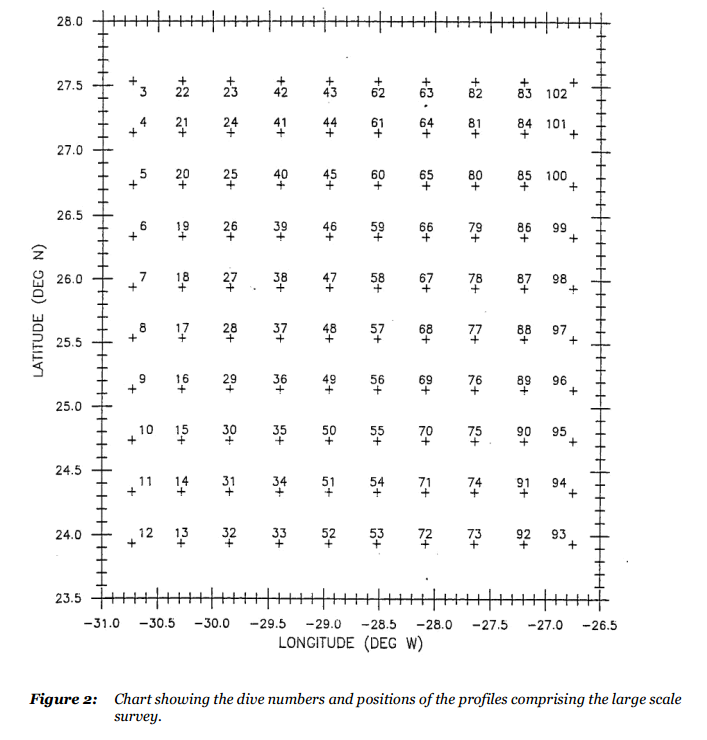

In [3]:
Image("../images/natre-large-scale.png")

## Read dataset

created using ``eddydiff.natre.combine_natre_files()``



In [4]:
natre = xr.open_dataset(
    "../datasets/natre_large_scale.nc", chunks={"latitude": 5, "longitude": 5}
)
natre = natre.where(natre.chi.notnull() & natre.eps.notnull())
natre = natre.set_coords(["time", "pres"])
natre = natre.cf.guess_coord_axis()

natre.chi.attrs["long_name"] = "$χ$"
natre.eps.attrs["long_name"] = "$ε$"
natre["depth"].attrs.update(units="m", positive="down")

In [5]:
natre = ed.sections.add_ancillary_variables(natre, pref=1000)
natre = natre.where(natre.chi > 1e-14)
natre.load()

<xarray.Dataset>
Dimensions:             (depth: 7961, latitude: 10, longitude: 10)
Coordinates:
    pres                (latitude, longitude, depth) float64 nan nan ... nan nan
    time                (latitude, longitude, depth) datetime64[ns] NaT ... NaT
  * depth               (depth) float64 10.2 10.6 11.0 ... 3.194e+03 3.194e+03
  * latitude            (latitude) float64 27.5 27.1 26.7 ... 24.7 24.3 23.9
  * longitude           (longitude) float64 -30.7 -30.3 -29.8 ... -27.2 -26.8
    reference_pressure  int64 1000
Data variables: (12/15)
    chi                 (latitude, longitude, depth) float64 nan nan ... nan nan
    eps                 (latitude, longitude, depth) float64 nan nan ... nan nan
    salt                (latitude, longitude, depth) float64 nan nan ... nan nan
    temp                (latitude, longitude, depth) float64 nan nan ... nan nan
    theta               (latitude, longitude, depth) float64 nan nan ... nan nan
    pden                (latitude, longitude, depth) float64 nan nan ... nan nan
    ...                  ...
    chi_masked          (latitude, longitude, depth) float64 nan nan ... nan nan
    Krho                (latitude, longitude, depth) float64 nan nan ... nan nan
    KrhoTz              (latitude, longitude, depth) float64 nan nan ... nan nan
    eps_chi             (latitude, longitude, depth) float64 nan nan ... nan nan
    Kt                  (latitude, longitude, depth) float64 nan nan ... nan nan
    KtTz                (latitude, longitude, depth) float64 nan nan ... nan nan
Attributes: (12/13)
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               North Atlantic Tracer Release Experiment (NATRE)
    expocode:              32OC250_4
    cast_number:           3.0
    title:                 Microstructure profiler data from the ship Oceanus...
    ...                    ...
    latitude:              27.533166666666666
    longitude:             -30.723333333333333
    chief_scientist:       Raymond W. Schmitt
    data_originator:       Polzin
    institution:           WHOI
    data_assembly_center:  CCHDO

/home/deepak/work/python/xarray/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/home/deepak/work/python/xarray/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


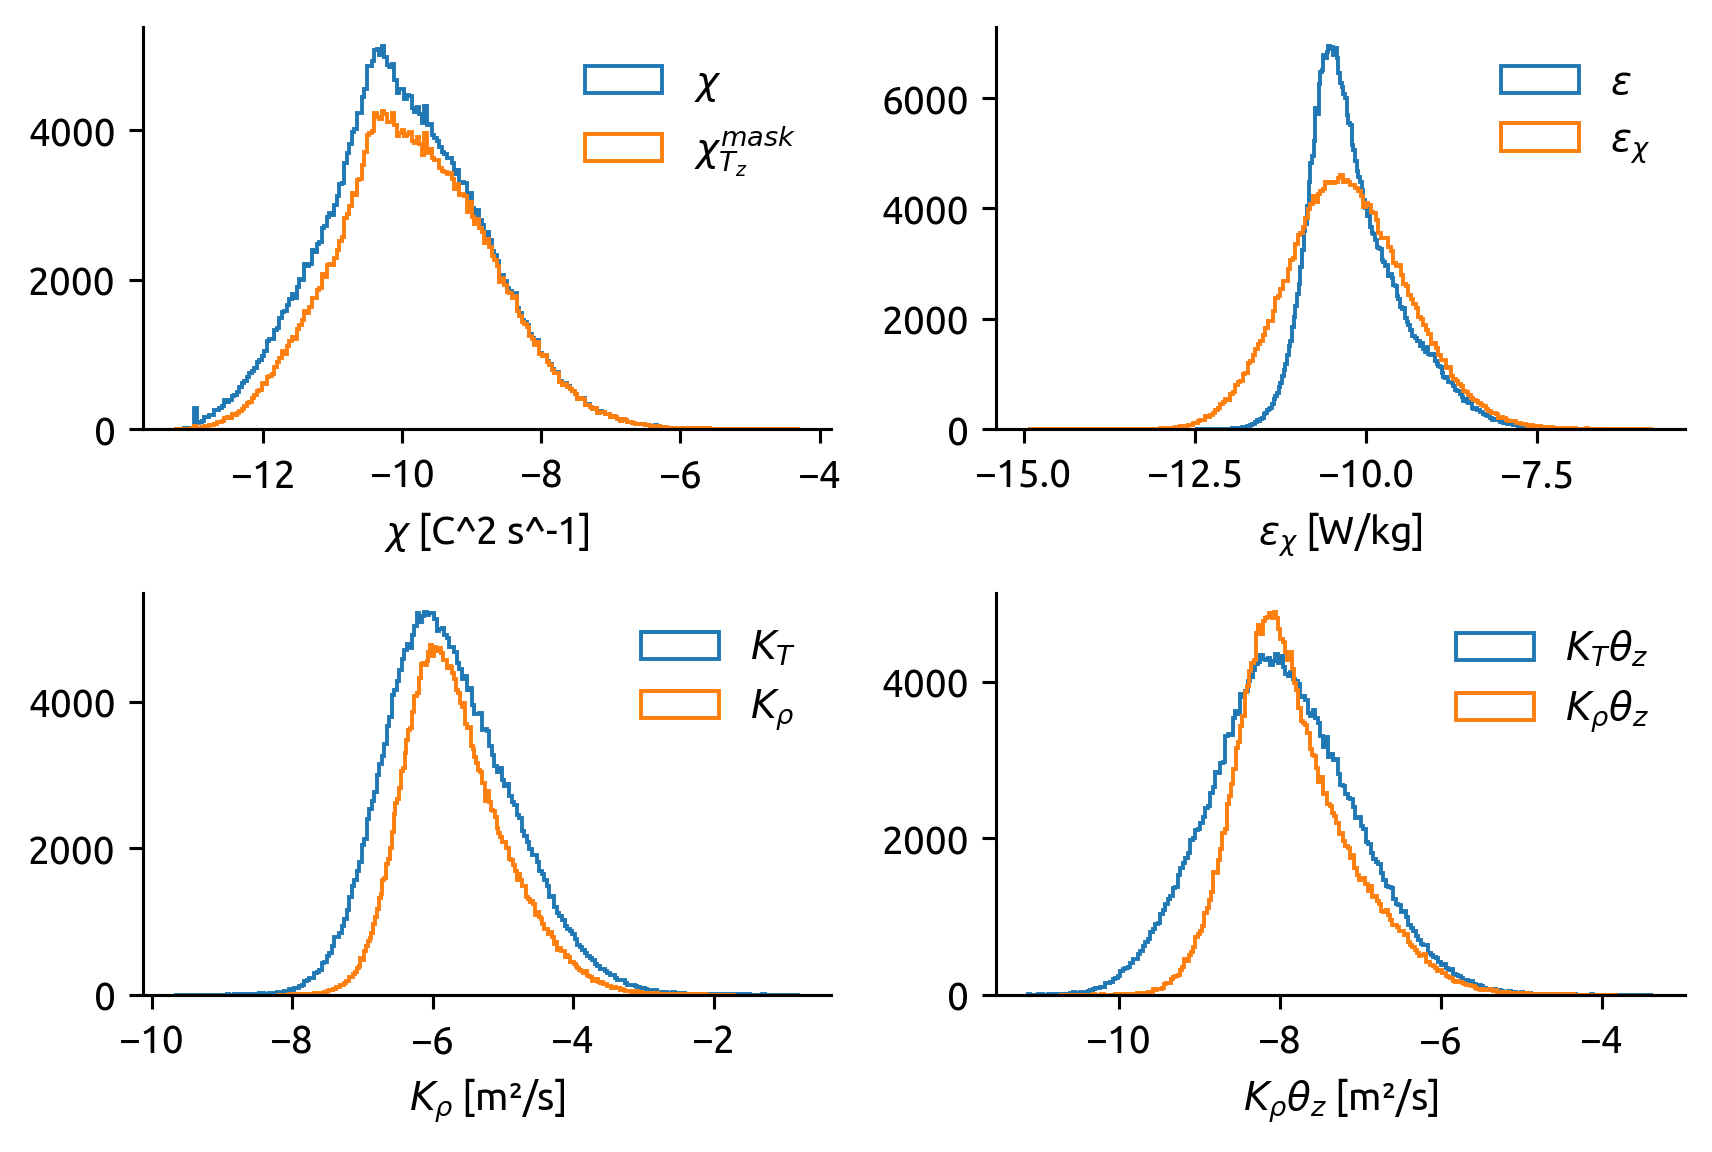

In [7]:
ed.plot.histogram_turb_estimates(natre)

## TS plot

/home/deepak/miniconda3/envs/dcpy/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


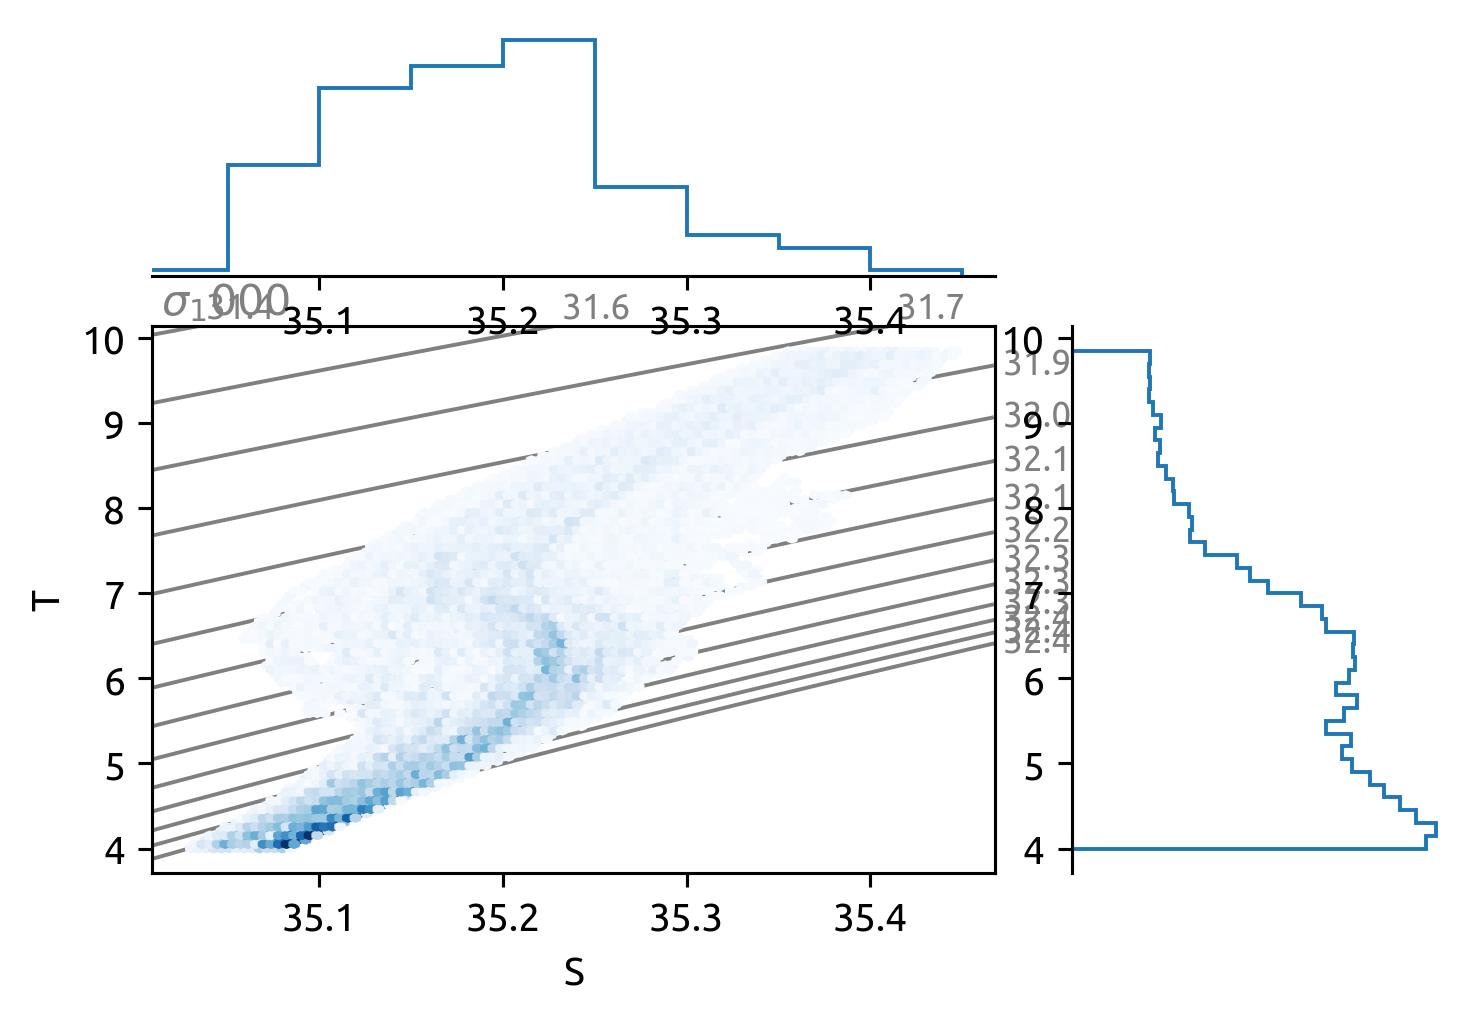

In [9]:
hdl, axes = dcpy.oceans.TSplot(
    natre.salt,
    natre.theta,
    Pref=1000,
    rho_levels=bins,
    Sbins=np.arange(35, 35.5, 0.05),
    Tbins=np.arange(4, 10, 0.15),
)

In [37]:
(
    natre["chi"].rolling(depth=100, center=True, min_periods=1).mean().compute()
).plot.line(`
    y="depth",
    col="longitude",
    row="latitude",
    yincrease=False,
    xlim=[1e-12, 1e-7],
    ylim=(2000, 0),
    xscale="log",
)

## Procedure

The large-scale average operator ⟨⟩ represents 
1. a horizontal average over the survey lateral scale,
2. a vertical average over O(100) m, and
3. a time average over the 18-day survey.


The mean fields are derived by averaging all variables along neutral-density surfaces $γ_n$

Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$,
$S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

In theory, these bins are approx. 100m apart in neutral density

### Choose bins

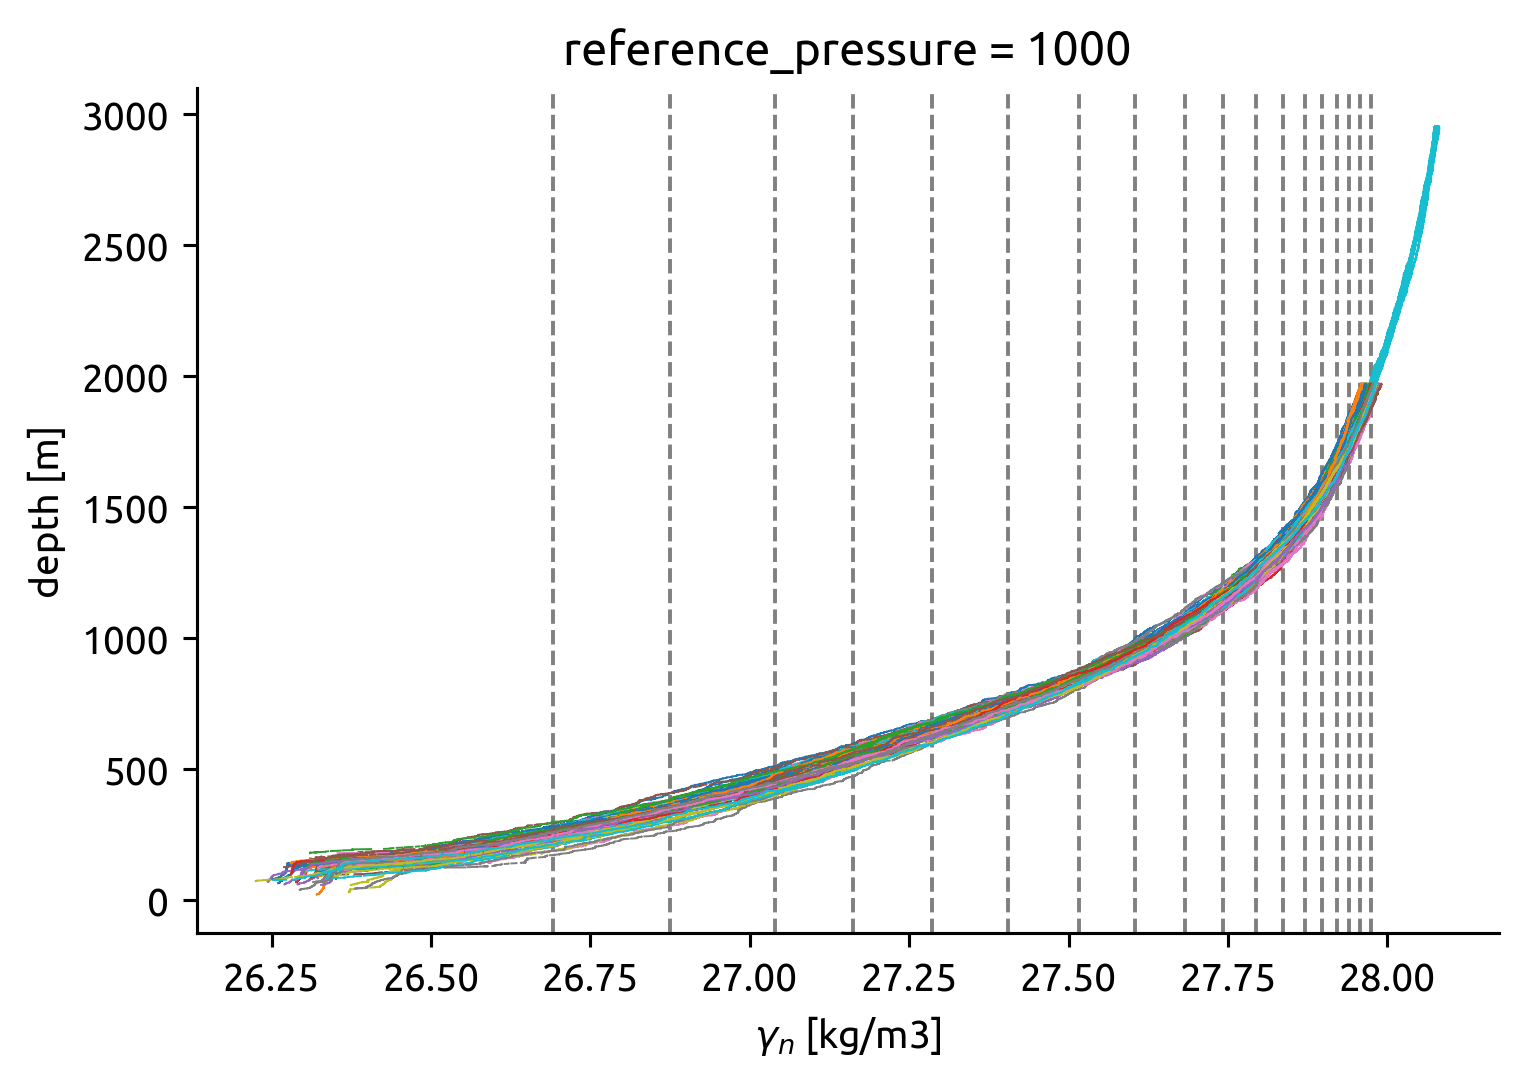

In [313]:
bins = (
    natre.gamma_n.mean(["latitude", "longitude"])
    .interp(depth=np.arange(150, 2001, 100))
    .dropna("depth")
    .data
)
natre.gamma_n.stack({"latlon": ["latitude", "longitude"]}).drop("latlon").cf.plot(
    hue="latlon", y="depth", lw=0.5, add_legend=False
)
dcpy.plots.linex(bins)

## Make estimate

### Vertical gradients: ed.sections.fit1D

> Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$, $S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

I don't understand this. The bins are O(100m) apart, so how do you "fit" straight lines over O(100)-m to a profile that has points every O(100)m.

### Horizontal gradients: ed.sections.fit2D

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

In [36]:
bins = (
    natre.gamma_n.mean(["latitude", "longitude"])
    .interp(depth=np.arange(150, 2001, 100))
    .dropna("depth")
    .data
)
chidens = ed.sections.bin_average_vertical(
    natre.reset_coords("pres"), "neutral_density", bins
)
chidens

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:             (gamma_n_bins: 17)
Coordinates:
  * gamma_n_bins        (gamma_n_bins) object (26.692, 26.876] ... (27.958, 2...
    pres                (gamma_n_bins) float64 302.4 405.7 ... 1.906e+03
    reference_pressure  int64 1000
Data variables: (12/19)
    chi                 (gamma_n_bins) float64 6.095e-09 3.71e-09 ... 2.339e-10
    eps                 (gamma_n_bins) float64 6.136e-10 5.582e-10 ... 1.094e-10
    salt                (gamma_n_bins) float64 36.16 35.87 35.68 ... 35.1 35.09
    temp                (gamma_n_bins) float64 15.65 13.86 12.45 ... 4.485 4.264
    theta               (gamma_n_bins) float64 15.76 13.95 12.52 ... 4.408 4.18
    pden                (gamma_n_bins) float64 1.031e+03 1.031e+03 ... 1.032e+03
    ...                  ...
    Kt                  (gamma_n_bins) float64 2.409e-05 2.355e-05 ... 1.413e-05
    KtTz                (gamma_n_bins) float64 1.383e-07 1.101e-07 ... 3.056e-08
    dTdz_m              (gamma_n_bins) float64 0.01871 0.01525 ... 0.002533
    N2_m                (gamma_n_bins) float64 1.958e-05 1.684e-05 ... 1.352e-06
    Krho_m              (gamma_n_bins) float64 6.268e-06 6.628e-06 ... 1.619e-05
    Kt_m                (gamma_n_bins) float64 8.705e-06 7.972e-06 ... 1.822e-05
Attributes: (12/13)
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               North Atlantic Tracer Release Experiment (NATRE)
    expocode:              32OC250_4
    cast_number:           3.0
    title:                 Microstructure profiler data from the ship Oceanus...
    ...                    ...
    latitude:              27.533166666666666
    longitude:             -30.723333333333333
    chief_scientist:       Raymond W. Schmitt
    data_originator:       Polzin
    institution:           WHOI
    data_assembly_center:  CCHDO

In [ ]:
for idx, (label, group) in enumerate(grouped):
    if idx == 10:
        break

ed.sections.fit1D(group, var="pden", debug=True)

for idx, (label, group) in enumerate(grouped):
    if idx == 15:
        break

ed.sections.fit1D(group, var="theta", debug=True)

Ke is totally wrong!, I need to fix my plane fitting

In [ ]:
chidens["Ke"] = (chidens.chi/2 - chidens.Krho_m * chidens.dTdz_m**2) / chidens.dTiso ** 2
chidens["Ke"].attrs["long_name"] = '$K_e$'
chidens["Ke"].attrs["units"] = "m²/s"
chidens["Ke"].cf.plot()

### Checking estimate

Replicate some Ferrari & Polzin (2005) figures. $K_ρ, ε$ look OK. $K_e$ is wrong, something is wrong with my slope estimate / plane fitting

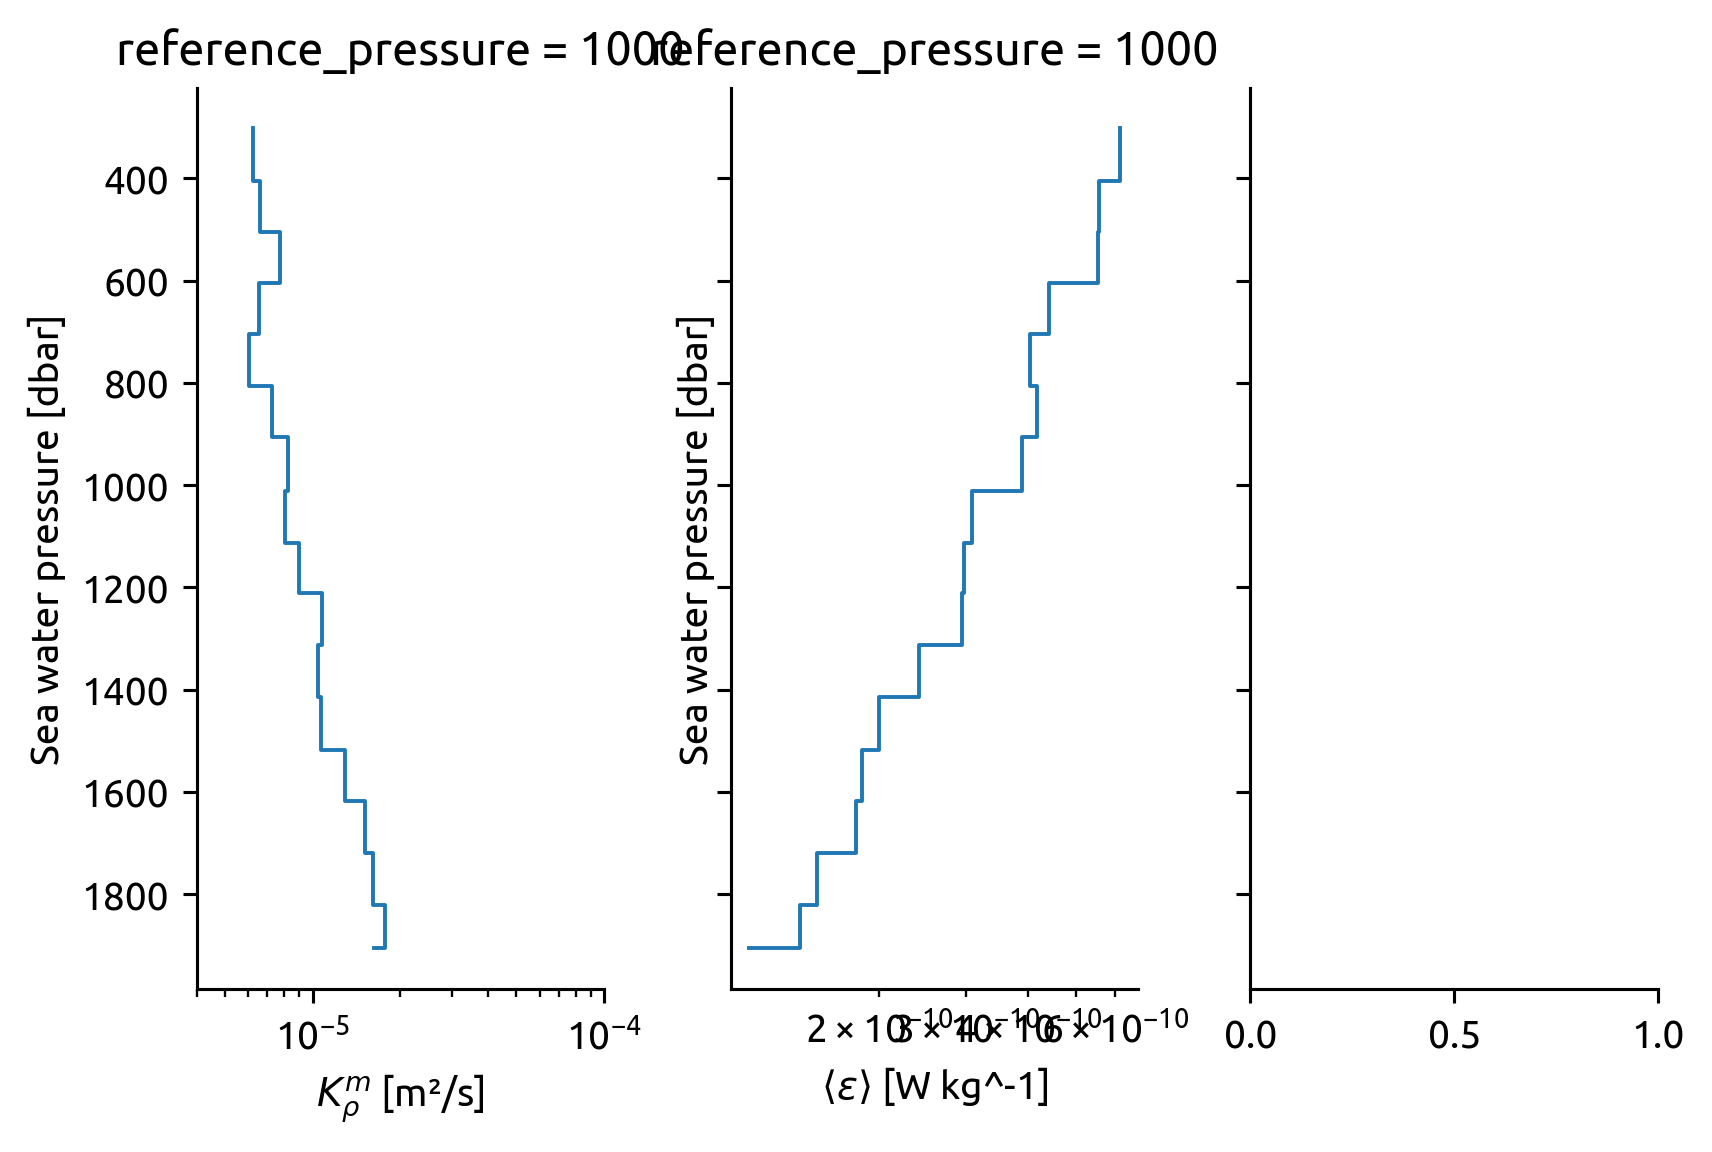

In [41]:
f, ax = plt.subplots(1, 3, sharey=True, constrained_layout=True)
chidens.Krho_m.cf.plot.step(xscale="log", xlim=(4e-6, 1e-4), ax=ax[0])
chidens.eps.cf.plot.step(ax=ax[1], xscale="log")
# chidens["Ke"].cf.plot(ax=ax[2])

## Reproducing production vs dissipation

Ferrari & Polzin use $⟨u_t θ_t⟩.∇θ_m = -Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$, we are instead doing $-⟨K_T θ_z⟩ ∂_zθ_m$. Our estimate mostly agrees with theirs. 


1. Filling in NaNs in the temperature profiles was important. This means more estimates are used in the averages
2. Masked where both $χ$ and $ε$ are both available.
3. Masked so that $|θ_z|$ > 1e-3 (really important, otherwise our estimate is too high)

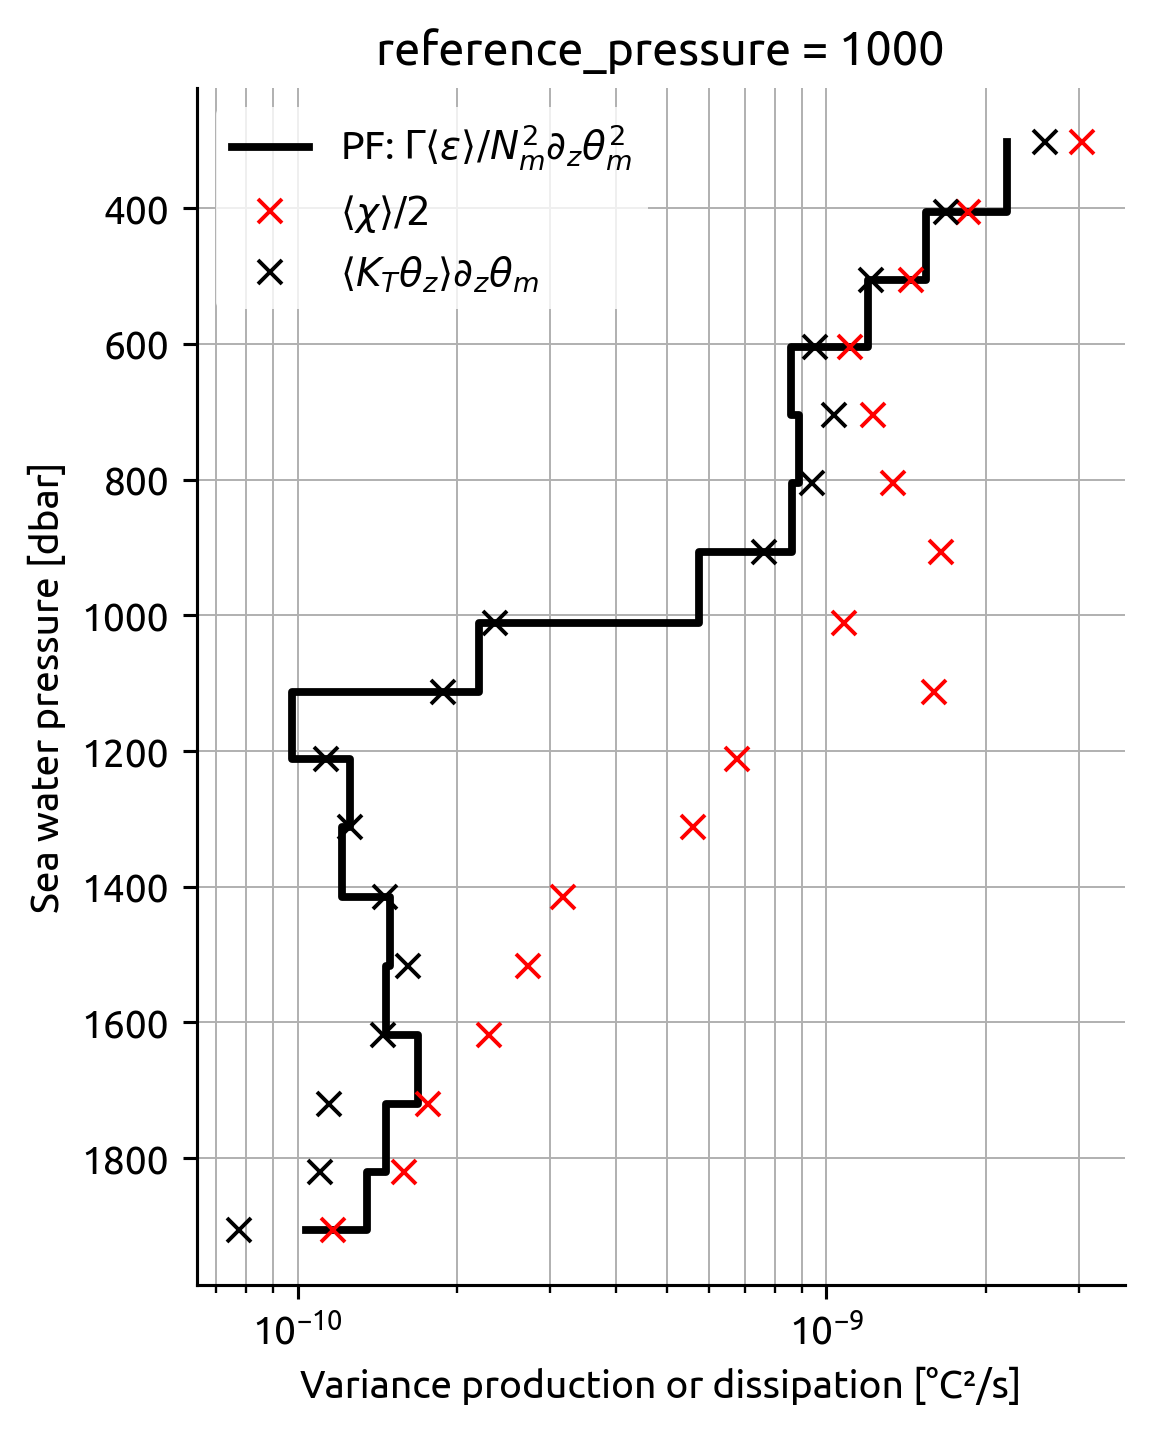

In [164]:
f, ax = plt.subplots(1, 1, constrained_layout=True)
(chidens.Krho_m * chidens.dTdz_m ** 2).cf.plot.step(
    color="k", lw=2, label="PF: $Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$"
)
ed.sections.plot_var_prod_diss(chidens, ls="none", marker="x", ax=plt.gca())

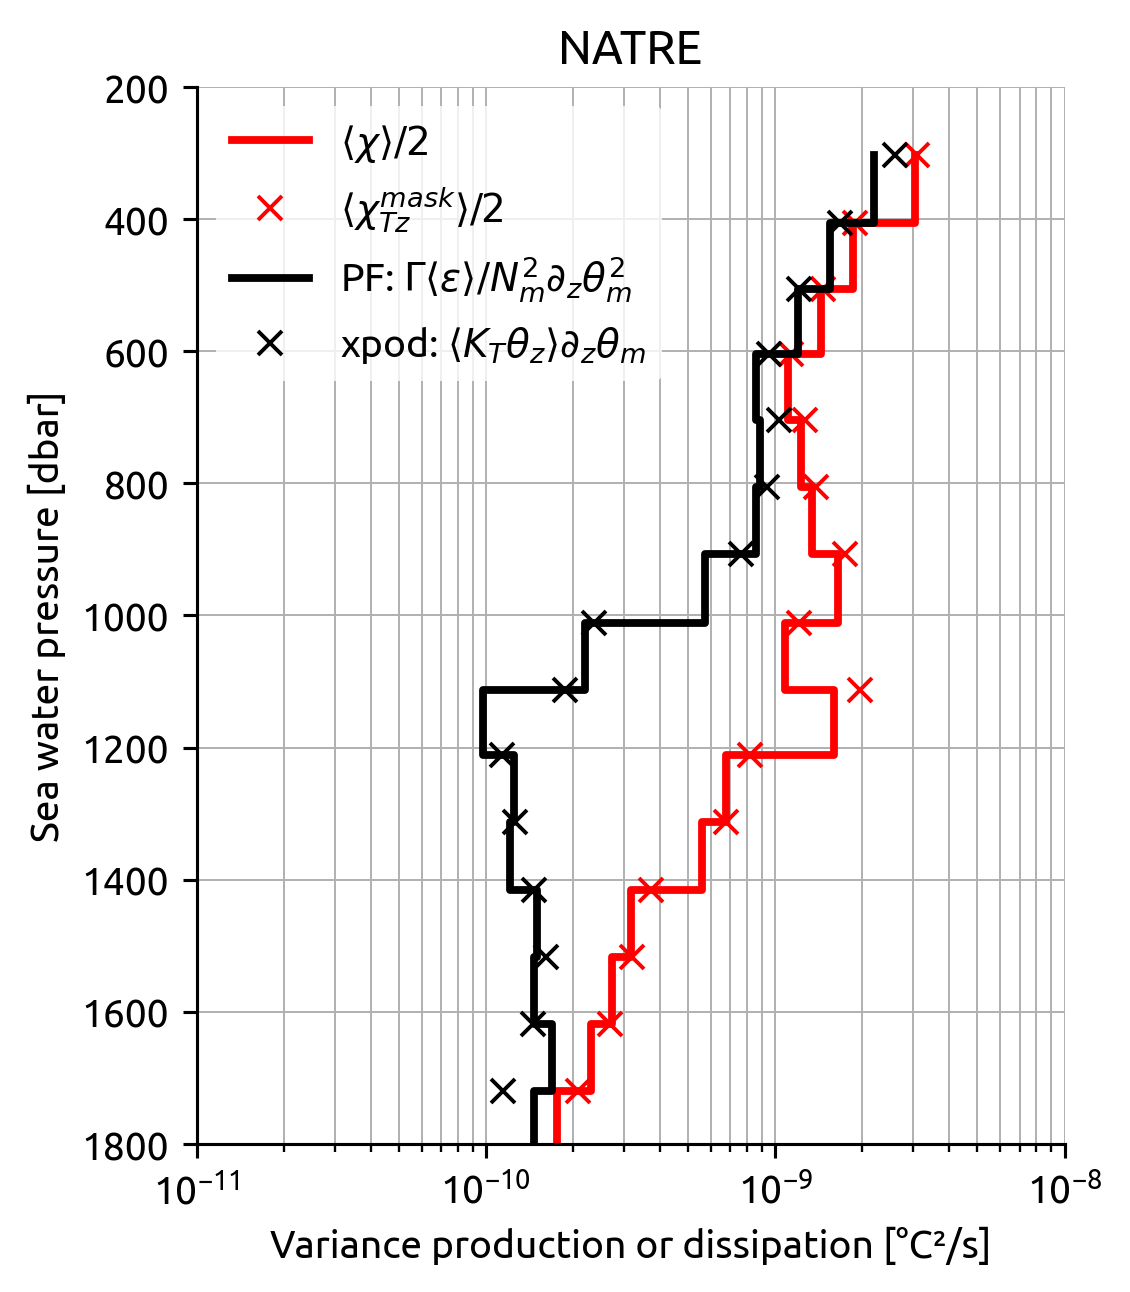

In [158]:
(chidens.chi / 2).cf.plot.step(
    y="pres",
    xscale="log",
    xlim=(1e-11, 1e-8),
    ylim=(1800, 200),
    color="r",
    lw=2,
    label="$⟨χ⟩/2$",
)
(chidens.chi_masked / 2).cf.plot.step(
    y="pres", color="r", label="$⟨χ^{mask}_{Tz}⟩/2$", ls="none", marker="x"
)


(chidens.KtTz * chidens.dTdz_m).cf.plot.step(
    color="k", marker="x", ls="none", label="χpod: $⟨K_T θ_z⟩ ∂_zθ_m$"
)
# (chidens.chi / 2 - chidens.Krho * chidens.dTdz ** 2).cf.plot.step(
#    y="pres",
#    xscale="log",
#    xlim=(1e-11, 1e-8),
#    ylim=(1800, 200),
#    color="darkblue",
#    lw=1,
#    label="$⟨χ⟩/2 - K_ρ θ^m_z$",
# )
plt.legend()
plt.xlabel("Variance production or dissipation [°C²/s]")
plt.gcf().set_size_inches((4, 5))
plt.title("NATRE")
plt.gcf().savefig("../images/natre-estimate.png")

## Sensitivity to mean K estimate

Various estimates of the variance produced by turbulent stirring of mean vertical gradient

1. Ferrai & Polzin (2005): $Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$ 
2. χpod estimate: $⟨K_T θ_z⟩ ∂_zθ_m$
3. (1) with $ε_χ$ : $Γ ⟨ε_χ⟩/N_m^2  ∂_zθ_m^2$
4. (2) with $K_ρ$ instead of $K_T$: $⟨K_ρ θ_z⟩  ∂_zθ_m^2$; $K_ρ ≪ K_T$, so this is not good

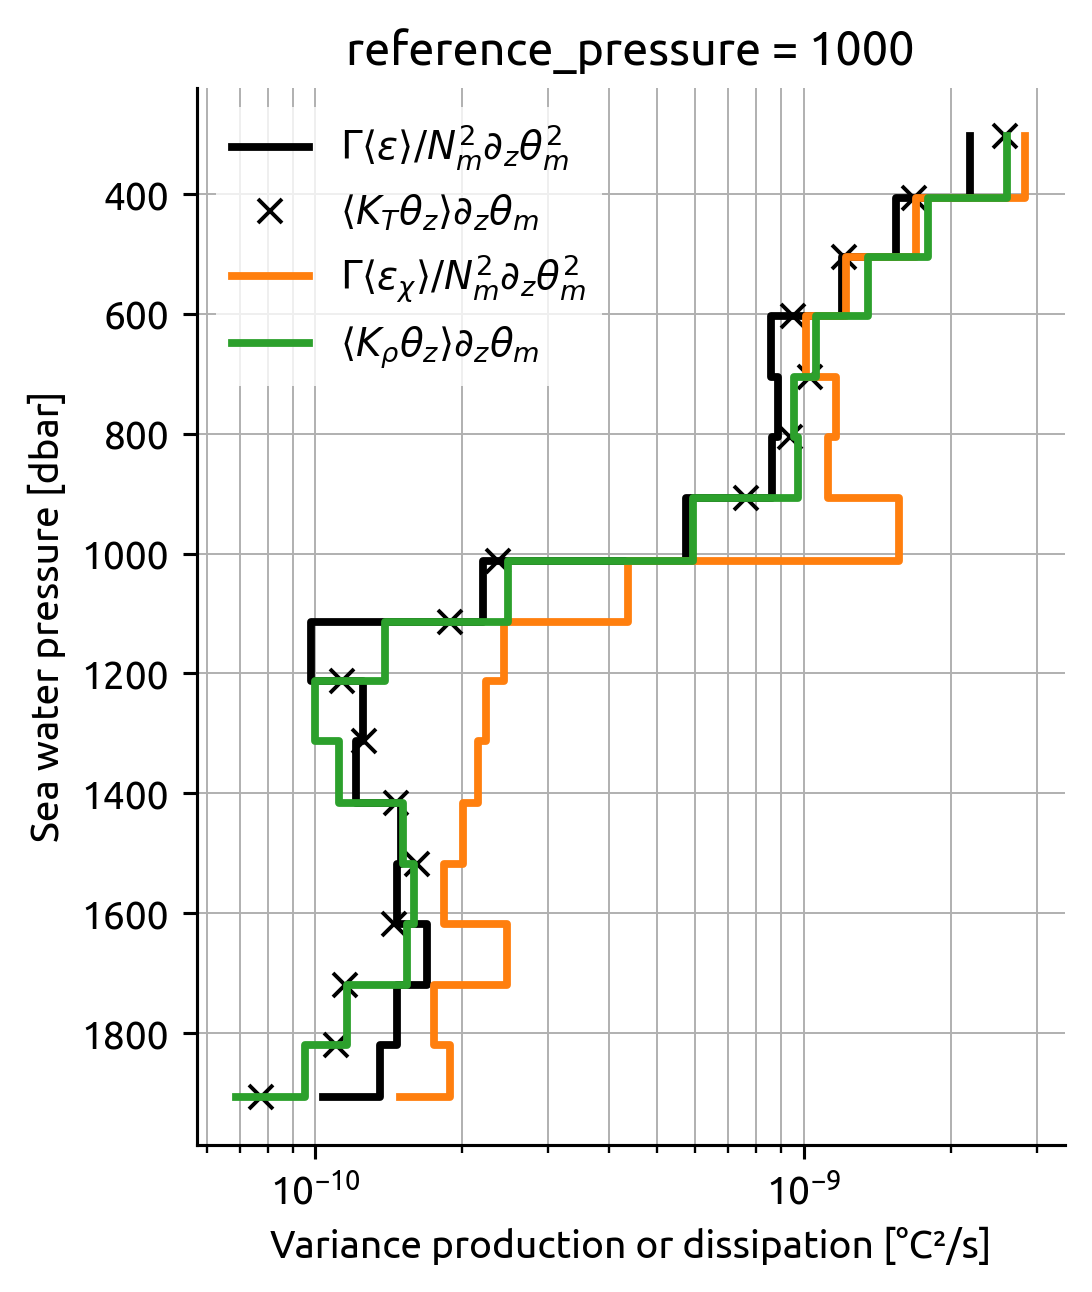

In [39]:
(chidens.Krho_m * chidens.dTdz_m ** 2).cf.plot.step(
    color="k", lw=2, label="$Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$"
)

(chidens.KtTz * chidens.dTdz_m).cf.plot.step(
    color="k", marker="x", ls="none", label="$⟨K_T θ_z⟩ ∂_zθ_m$"
)

(0.2 * chidens.eps_chi / chidens.N2_m * chidens.dTdz_m ** 2).cf.plot.step(
    color="C1", lw=2, label="$Γ ⟨ε_χ⟩/N_m^2  ∂_zθ_m^2$"
)

(chidens.KrhoTz * chidens.dTdz_m).cf.plot.step(
    lw=2, label="$⟨K_ρ θ_z⟩  ∂_zθ_m$", color="C2"
)

plt.grid(True, which="both", lw=0.5)

plt.legend()
plt.xscale("log")
plt.xlabel("Variance production or dissipation [°C²/s]")
plt.gcf().set_size_inches((4, 5))

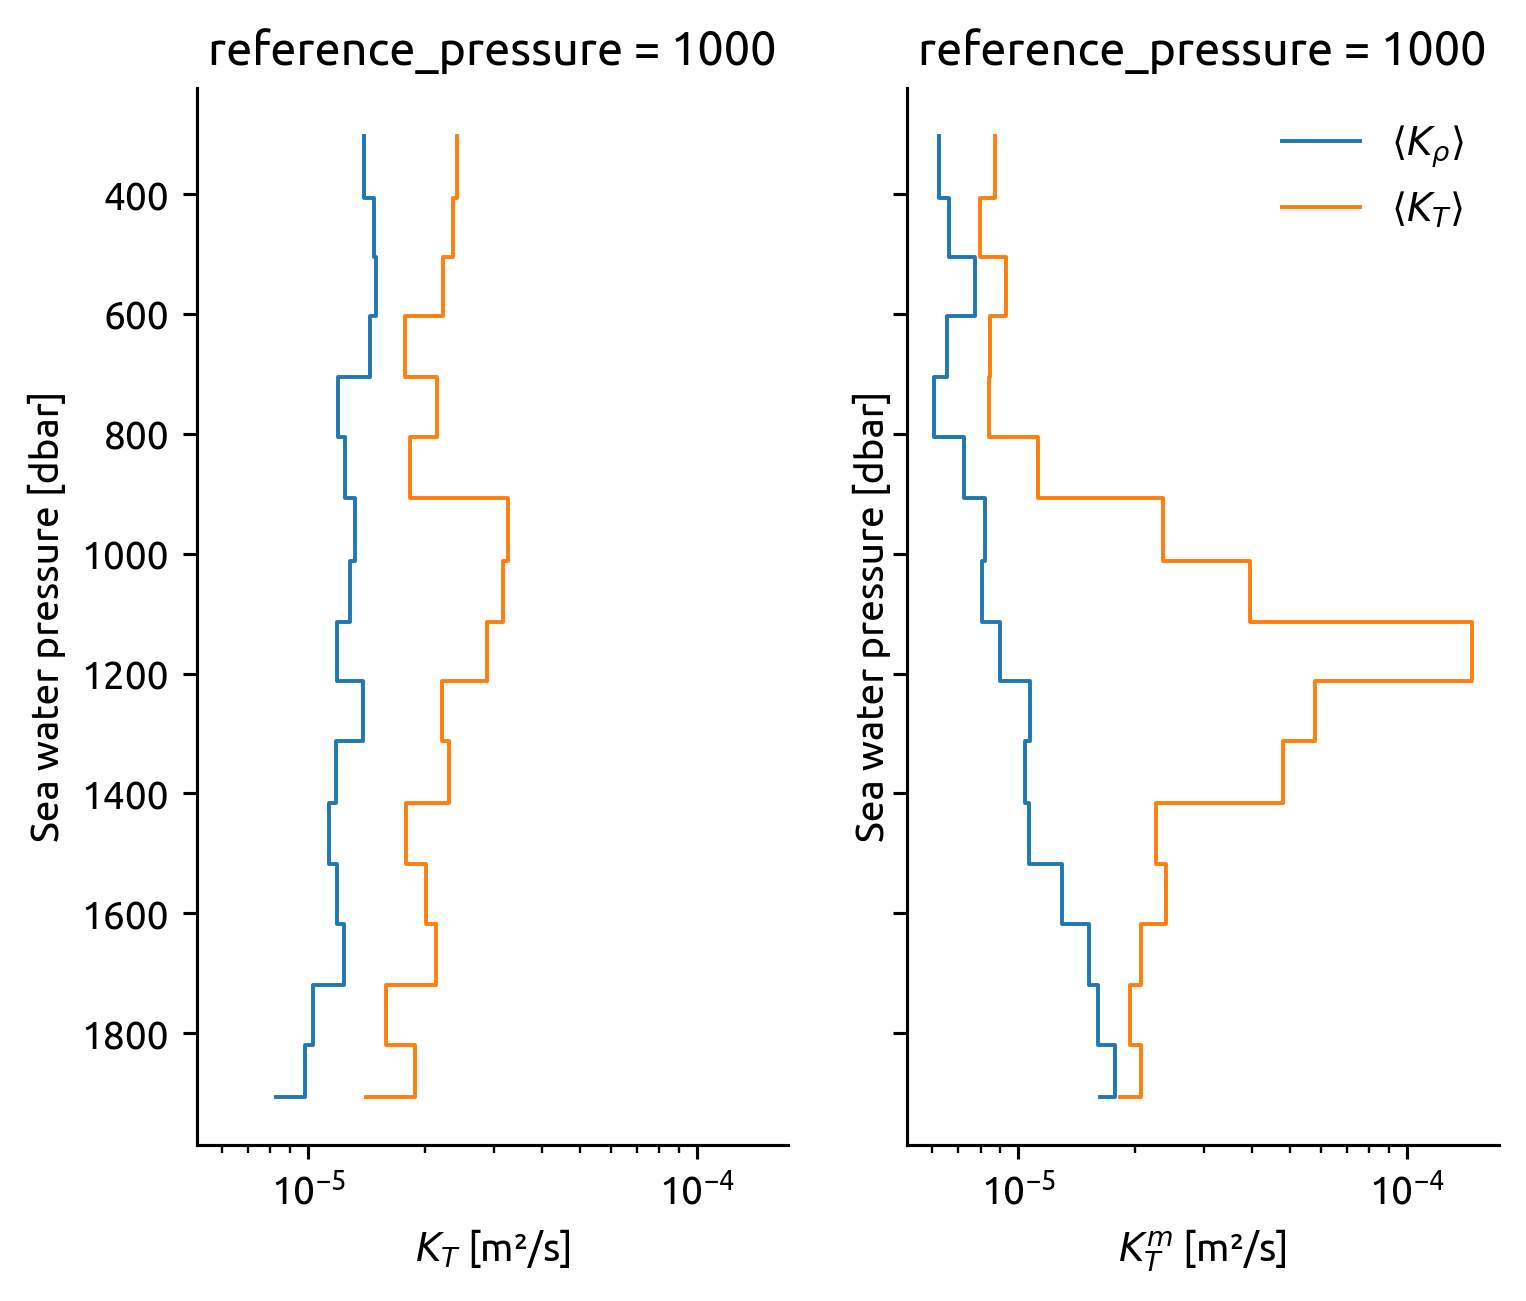

In [40]:
f, ax = plt.subplots(1, 2, sharey=True, sharex=True)
chidens.Krho.cf.plot.step(xscale="log", ax=ax[0])
chidens.Kt.cf.plot.step(ax=ax[0])
chidens.Krho_m.cf.plot.step(ax=ax[1])
chidens.Kt_m.cf.plot.step(ax=ax[1])
plt.legend(["$⟨K_ρ⟩$", "$⟨K_T⟩$", "$K_ρ^m = Γ ⟨ε⟩/N_m²$" "$K_T^m = ⟨χ⟩/2θ_m^2$"])
plt.gcf().set_size_inches((6, 5))


### Todo:

See sensitivity to using
1. [x] $⟨K_ρ θ_z⟩ θ_z^m = ⟨Γε/N² θ_z⟩ θ_z^m$
2. [x] Use $Γ ⟨ε_χ⟩/N_m^2$
3. [x] Using neutral density bins instead of $σ_{1}$
4. [x] $T_z$ filtering